In [14]:
import pandas as pd
import numpy as np

import string

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec

from pandas.api.types import CategoricalDtype 

#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score

import xgboost as xgb

#Models
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding

In [15]:
DATA_DIR = 'cat-in-the-dat/'

train_df = pd.read_csv(DATA_DIR + 'train.csv')
test_df = pd.read_csv(DATA_DIR + 'test.csv')
sub_df = pd.read_csv(DATA_DIR + 'sample_submission.csv')



## Plot Summary

In [16]:
def summary(df):
    summary = pd.DataFrame(df.dtypes, columns=['datatype'])
    
    summary['Missing'] = df.isna().sum().values    
    summary['Unique'] = df.nunique().values
    
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [17]:
summary(train_df)

,datatype,Missing,Unique,First Value,Second Value,Third Value
id,int64,0,300000,0,1,2
bin_0,int64,0,2,0,0,0
bin_1,int64,0,2,0,1,0
bin_2,int64,0,2,0,0,0
bin_3,object,0,2,T,T,F
bin_4,object,0,2,Y,Y,Y
nom_0,object,0,3,Green,Green,Blue
nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
nom_2,object,0,6,Snake,Hamster,Lion
nom_3,object,0,6,Finland,Russia,Russia


In [18]:
summary(test_df)

,datatype,Missing,Unique,First Value,Second Value,Third Value
id,int64,0,200000,300000,300001,300002
bin_0,int64,0,2,0,0,1
bin_1,int64,0,2,0,0,0
bin_2,int64,0,2,1,0,1
bin_3,object,0,2,T,T,F
bin_4,object,0,2,Y,N,Y
nom_0,object,0,3,Blue,Red,Blue
nom_1,object,0,6,Triangle,Square,Square
nom_2,object,0,6,Axolotl,Lion,Dog
nom_3,object,0,6,Finland,Canada,China


The data contains binary features (bin_*), nominal features (nom_*), ordinal features (ord_*) as well as (potentially cyclical) day (of the week) and month features. The string ordinal features ord_{3-5} are lexically ordered according to string.ascii_letters.

## Plot Target Variable

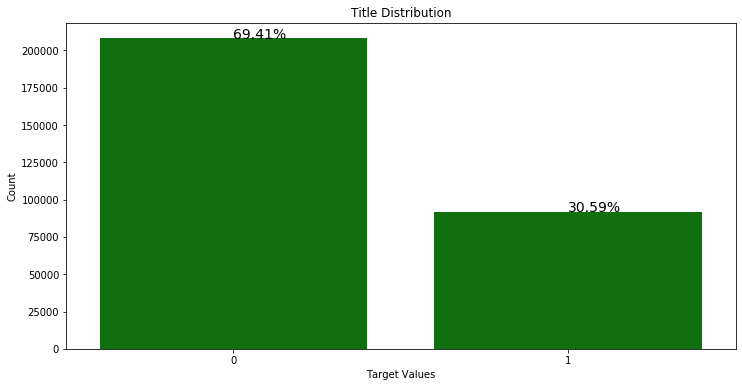

In [19]:
total = len(train_df)
plt.figure(figsize=(12,6))

plot = sns.countplot(x = 'target', data = train_df, color = 'green')
plot.set_title('Title Distribution')
plot.set_xlabel('Target Values')
plot.set_ylabel('Count')

for patch in plot.patches:
    height = patch.get_height()
    plot.text(patch.get_x() + patch.get_width()/2, # X + half of width
             patch.get_height() + 3,
             '{:1.2f}%'.format(height/total*100),
             fontsize = 14)

plt.show()

No Class imbalance in data

## Convert Categorical Variables to Numbers
1. Binary Variables

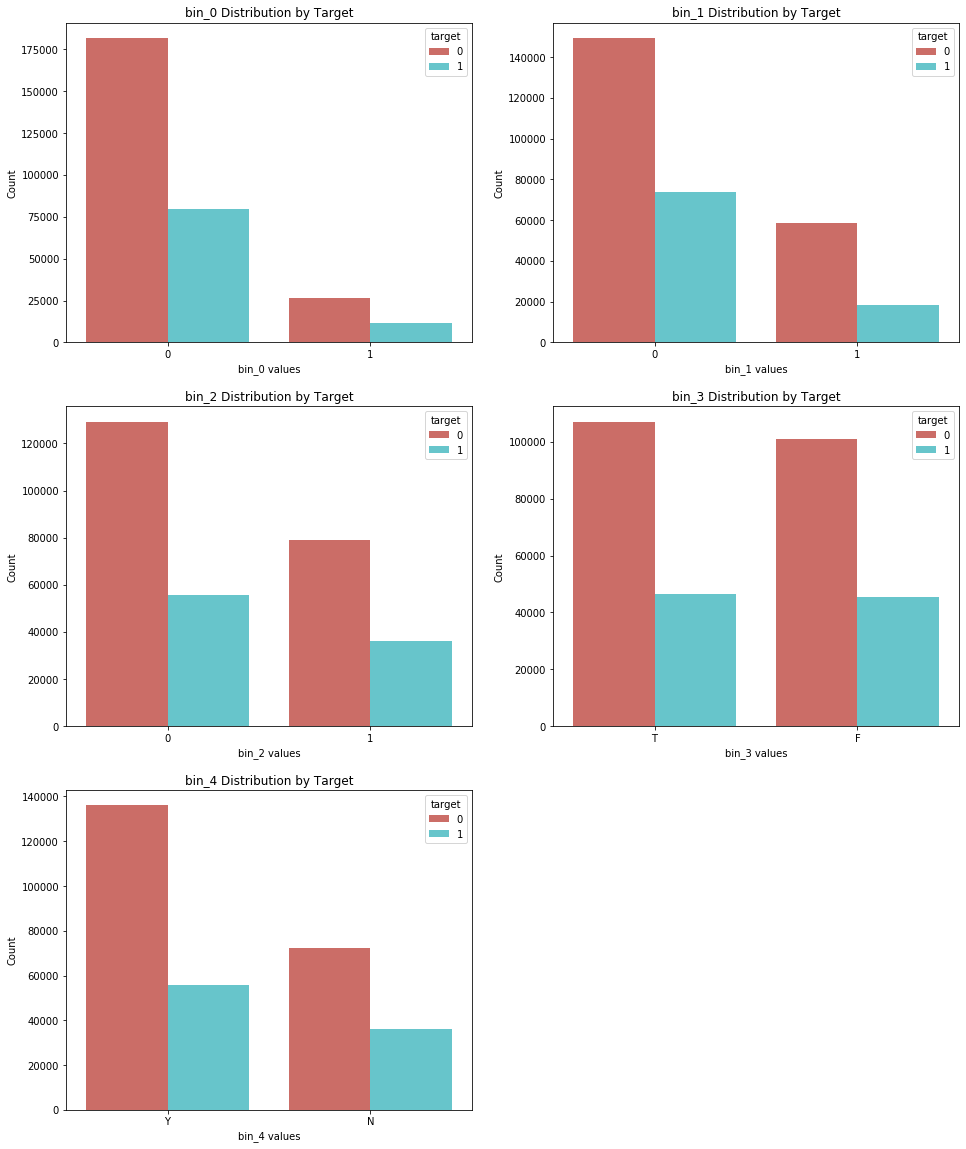

In [20]:
grid = gridspec.GridSpec(3,2)
plt.figure(figsize=(16,20))

for num, column in enumerate(train_df.filter(regex=('bin_*')).columns):
    plot = plt.subplot(grid[num])
    
    sns.countplot(x = column, data = train_df, hue='target', palette='hls')
    plot.set_title(f'{column} Distribution by Target')
    plot.set_xlabel(f'{column} values')
    plot.set_ylabel('Count')
    
plt.show()

In [21]:
for column in train_df.filter(regex=('bin_*')).columns:
    print(f"Ordinal Column {column} \n{train_df[column].value_counts()}\n")

Ordinal Column bin_0 
0    261749
1     38251
Name: bin_0, dtype: int64

Ordinal Column bin_1 
0    223018
1     76982
Name: bin_1, dtype: int64

Ordinal Column bin_2 
0    185033
1    114967
Name: bin_2, dtype: int64

Ordinal Column bin_3 
T    153535
F    146465
Name: bin_3, dtype: int64

Ordinal Column bin_4 
Y    191633
N    108367
Name: bin_4, dtype: int64



Since bin_1, bin_2 and bin_3 are already numbers. we need to only convert bin_r and bin_5


In [22]:
values_map = {'T' : 1, 'F' : 0, 'Y' : 1, 'N' : 0}

train_df['bin_3'] = train_df['bin_3'].map(values_map)
train_df['bin_4'] = train_df['bin_4'].map(values_map)
test_df['bin_3'] = test_df['bin_3'].map(values_map)
test_df['bin_4'] = test_df['bin_4'].map(values_map)

2. Nominal Variables<br/>
Now, we will check Nominal variables (with more than 2 and less than 15 values)

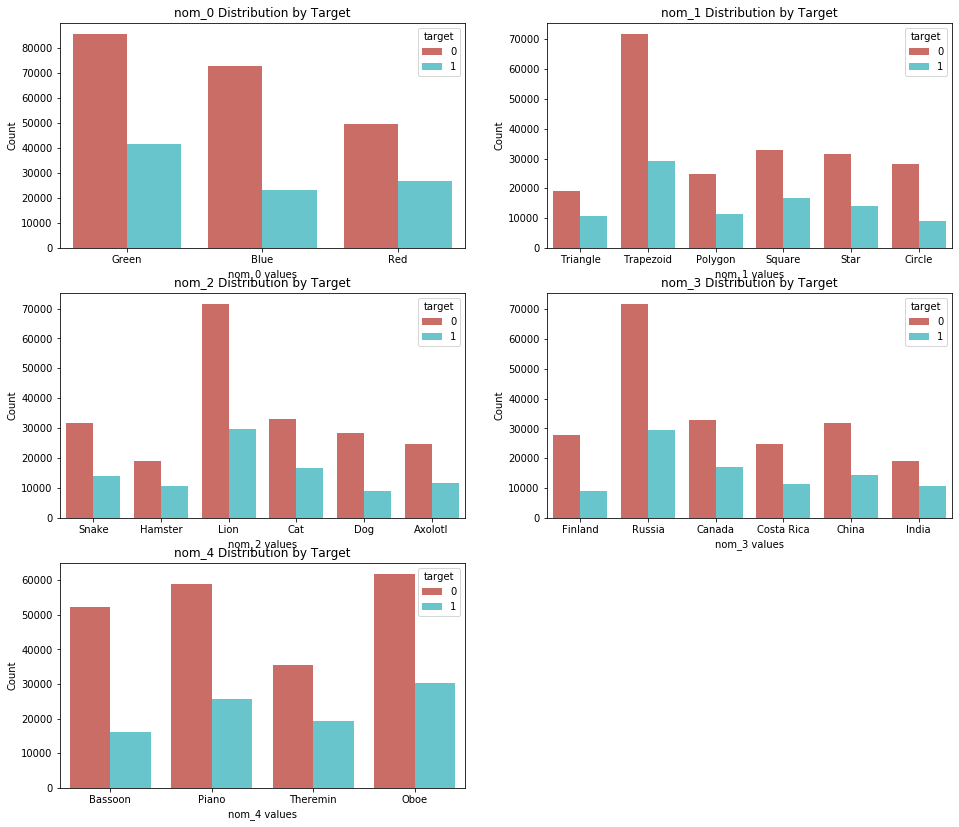

In [23]:
grid = gridspec.GridSpec(5,2)
plt.figure(figsize=(16,24))

nom_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']

for num, column in enumerate(train_df[nom_cols].columns):
    plot = plt.subplot(grid[num])
    
    sns.countplot(x = column, data = train_df, hue='target', palette='hls')
    plot.set_title(f'{column} Distribution by Target')
    plot.set_xlabel(f'{column} values')
    plot.set_ylabel('Count')
    
plt.show()

In [24]:
test_df['target'] = 'test_target'
df = pd.concat([train_df, test_df], axis=0, sort=False )

df = pd.get_dummies(df, columns=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],\
                          prefix=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], drop_first=True)

train_df, test_df = df[df['target'] != 'test_target'], df[df['target'] == 'test_target'].drop('target', axis=1)
del df

In [25]:
train_df.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_5', 'nom_6',
       'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
       'ord_5', 'day', 'month', 'target', 'nom_0_Green', 'nom_0_Red',
       'nom_1_Polygon', 'nom_1_Square', 'nom_1_Star', 'nom_1_Trapezoid',
       'nom_1_Triangle', 'nom_2_Cat', 'nom_2_Dog', 'nom_2_Hamster',
       'nom_2_Lion', 'nom_2_Snake', 'nom_3_China', 'nom_3_Costa Rica',
       'nom_3_Finland', 'nom_3_India', 'nom_3_Russia', 'nom_4_Oboe',
       'nom_4_Piano', 'nom_4_Theremin'],
      dtype='object')

3. Ordinal Features<br>
 (with more than 2 and less than 15 values)

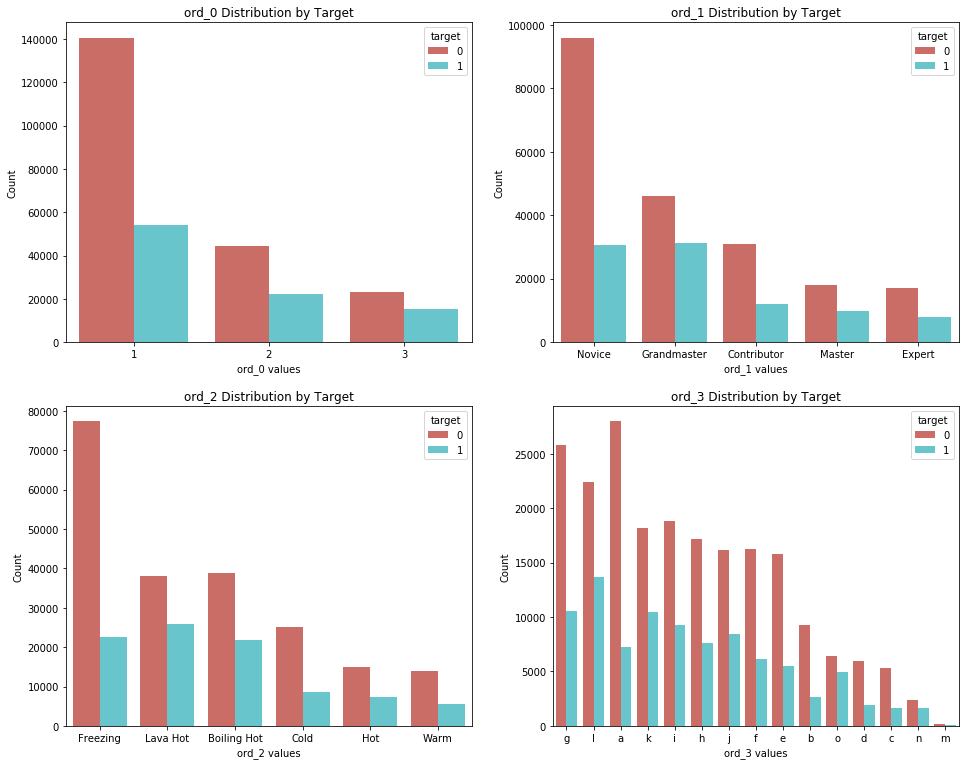

In [26]:
grid = gridspec.GridSpec(3,2)
plt.figure(figsize=(16,20))

ord_cols = ['ord_0', 'ord_1', 'ord_2', 'ord_3']

for num, column in enumerate(train_df[ord_cols].columns):
    plot = plt.subplot(grid[num])
    
    sns.countplot(x = column, data = train_df, hue='target', palette='hls', order = train_df[column].value_counts().index)
    plot.set_title(f'{column} Distribution by Target')
    plot.set_xlabel(f'{column} values')
    plot.set_ylabel('Count')
    
plt.show()

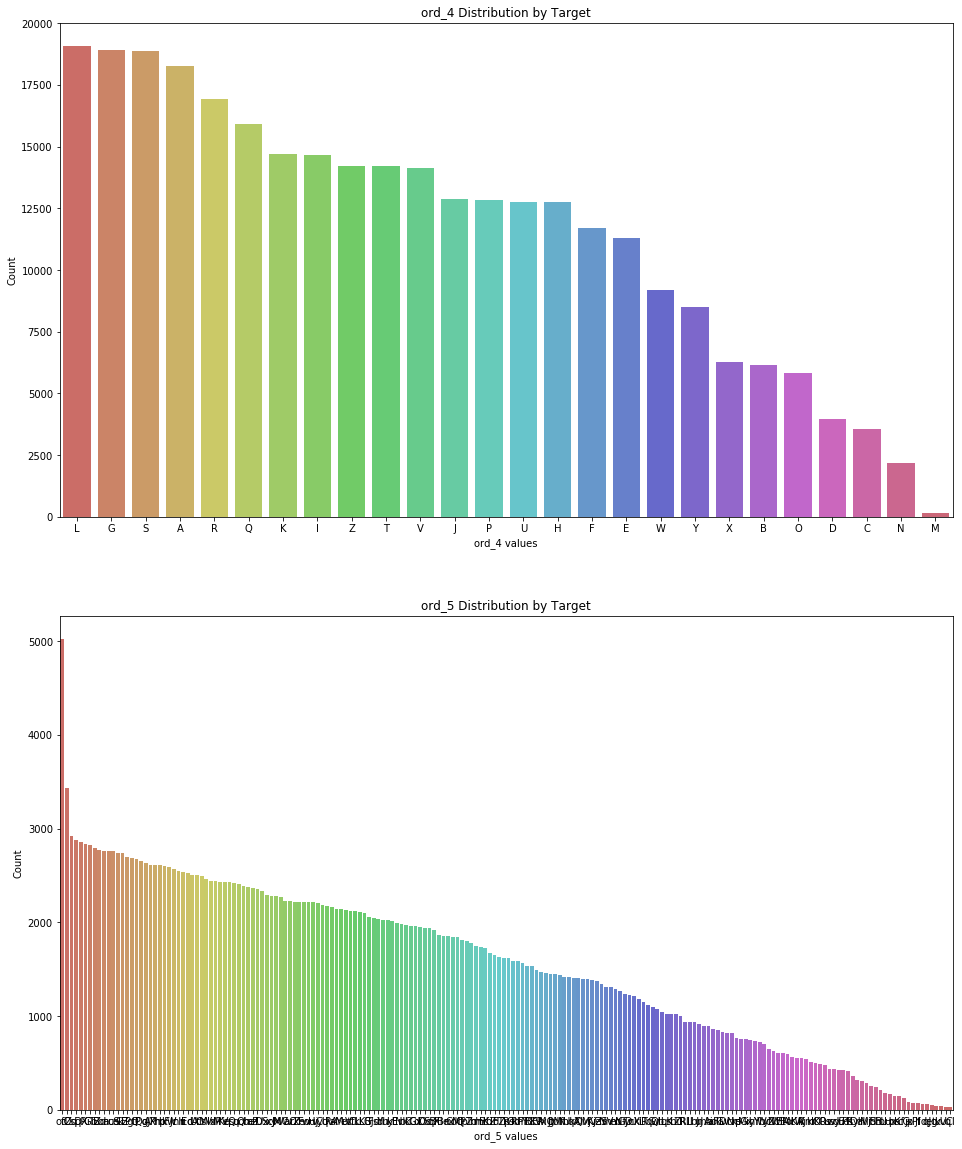

In [27]:
grid = gridspec.GridSpec(2,1)
plt.figure(figsize=(16,20))

ord_cols = ['ord_4', 'ord_5']

for num, column in enumerate(train_df[ord_cols].columns):
    plot = plt.subplot(grid[num])
    
    sns.countplot(x = column, data = train_df, palette='hls', order=train_df[column].value_counts().index)
    plot.set_title(f'{column} Distribution by Target')
    plot.set_xlabel(f'{column} values')
    plot.set_ylabel('Count')
    
plt.show()

In [28]:
# seting the orders of our ordinal features
ord_1 = CategoricalDtype(categories=['Novice', 'Contributor','Expert', 
                                     'Master', 'Grandmaster'], ordered=True)
ord_2 = CategoricalDtype(categories=['Freezing', 'Cold', 'Warm', 'Hot',
                                     'Boiling Hot', 'Lava Hot'], ordered=True)
ord_3 = CategoricalDtype(categories=['a', 'b', 'c', 'd', 'e', 'f', 'g',
                                     'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o'], ordered=True)
ord_4 = CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
                                     'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
                                     'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], ordered=True)

# Transforming ordinal Features
train_df.ord_1 = train_df.ord_1.astype(ord_1)
train_df.ord_2 = train_df.ord_2.astype(ord_2)
train_df.ord_3 = train_df.ord_3.astype(ord_3)
train_df.ord_4 = train_df.ord_4.astype(ord_4)

# test dataset
test_df.ord_1 = test_df.ord_1.astype(ord_1)
test_df.ord_2 = test_df.ord_2.astype(ord_2)
test_df.ord_3 = test_df.ord_3.astype(ord_3)
test_df.ord_4 = test_df.ord_4.astype(ord_4)

In [29]:
# Geting the codes of ordinal categoy's - train
train_df.ord_1 = train_df.ord_1.cat.codes
train_df.ord_2 = train_df.ord_2.cat.codes
train_df.ord_3 = train_df.ord_3.cat.codes
train_df.ord_4 = train_df.ord_4.cat.codes

# Geting the codes of ordinal categoy's - test
test_df.ord_1 = test_df.ord_1.cat.codes
test_df.ord_2 = test_df.ord_2.cat.codes
test_df.ord_3 = test_df.ord_3.cat.codes
test_df.ord_4 = test_df.ord_4.cat.codes

4. Cyclical Features<br/>
encode cyclical features into two dimensional cyclical sin-cos features

In [30]:
def date_cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_vals)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_vals)
    return df

train_df = date_cyc_enc(train_df, 'day', 7)
test_df = date_cyc_enc(test_df, 'day', 7) 

train_df = date_cyc_enc(train_df, 'month', 12)
test_df = date_cyc_enc(test_df, 'month', 12)

train_df.drop(['day', 'month'], axis = 1, inplace = True)
test_df.drop(['day', 'month'], axis = 1, inplace = True)

5. Features with high Cardinality

In [31]:
# # Then encode 'ord_5' using ACSII values

# # Option 1: Add up the indices of two letters in string.ascii_letters
# train['ord_5_oe_add'] = train['ord_5'].apply(lambda x:sum([(string.ascii_letters.find(letter)+1) for letter in x]))
# test['ord_5_oe_add'] = test['ord_5'].apply(lambda x:sum([(string.ascii_letters.find(letter)+1) for letter in x]))

# # Option 2: Join the indices of two letters in string.ascii_letters
# train['ord_5_oe_join'] = train['ord_5'].apply(lambda x:float(''.join(str(string.ascii_letters.find(letter)+1) for letter in x)))
# test['ord_5_oe_join'] = test['ord_5'].apply(lambda x:float(''.join(str(string.ascii_letters.find(letter)+1) for letter in x)))

# # Option 3: Split 'ord_5' into two new columns using the indices of two letters in string.ascii_letters, separately
train_df['ord_5_oe1'] = train_df['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))
test_df['ord_5_oe1'] = test_df['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))

train_df['ord_5_oe2'] = train_df['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))
test_df['ord_5_oe2'] = test_df['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))

# Option 4: Simply sort their values by string
# https://www.kaggle.com/c/cat-in-the-dat/discussion/105702#latest-607652
ord_5 = sorted(list(set(train_df['ord_5'].values)))
ord_5 = dict(zip(ord_5, range(len(ord_5))))
train_df.loc[:, 'ord_5'] = train_df['ord_5'].apply(lambda x: ord_5[x]).astype(float)
test_df.loc[:, 'ord_5'] = test_df['ord_5'].apply(lambda x: ord_5[x]).astype(float)

In [32]:
high_card_feats = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']


# Label Encoding
for f in high_card_feats:
    if train_df[f].dtype=='object' or test_df[f].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values) + list(test_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))  

In [33]:
%%time

train_df = reduce_mem_usage(train_df)

test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 30.60 Mb (52.9% reduction)
Mem. usage decreased to 12.21 Mb (65.2% reduction)
CPU times: user 123 ms, sys: 37.2 ms, total: 161 ms
Wall time: 158 ms


## Setting up X and Y

In [34]:
X_train = train_df.drop(["id","target"], axis=1)
y_train = train_df["target"]
y_train = y_train.astype(bool)

X_test = test_df.drop(["id"],axis=1)

## Cross Val Score

In [35]:
"""
%%time

clfs = []
seed = 42

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("XGBClassifier",
             Pipeline([("XGB", XGBClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("RandomForest", RandomForestClassifier(n_estimators=100))]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("GradientBoosting", GradientBoostingClassifier(n_estimators=100))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("ExtraTrees", ExtraTreesClassifier())])))

scoring = 'roc_auc'
n_folds = 10

results, names  = [], [] 

kfold = KFold(n_splits=n_folds, shuffle=False, random_state=seed)

for name, model  in clfs:
    cv_results = cross_val_score(model, 
                                 X_train.values, y_train, 
                                 cv= kfold, scoring=scoring,
                                 n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    print(msg)

    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20) 
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.show()
"""

'\n%%time\n\nclfs = []\nseed = 42\n\nclfs.append(("LogReg", \n             Pipeline([("Scaler", StandardScaler()),\n                       ("LogReg", LogisticRegression())])))\n\nclfs.append(("XGBClassifier",\n             Pipeline([("XGB", XGBClassifier())]))) \n\nclfs.append(("DecisionTreeClassifier", \n             Pipeline([("DecisionTrees", DecisionTreeClassifier())]))) \n\nclfs.append(("RandomForestClassifier", \n             Pipeline([("RandomForest", RandomForestClassifier(n_estimators=100))]))) \n\nclfs.append(("GradientBoostingClassifier", \n             Pipeline([("GradientBoosting", GradientBoostingClassifier(n_estimators=100))]))) \n\nclfs.append(("RidgeClassifier", \n             Pipeline([("Scaler", StandardScaler()),\n                       ("RidgeClassifier", RidgeClassifier())])))\n\nclfs.append(("BaggingClassifier",\n             Pipeline([("Scaler", StandardScaler()),\n                       ("BaggingClassifier", BaggingClassifier())])))\n\nclfs.append(("ExtraTreesC

In [36]:
%%time
# Ensemble Best performing Models

seed = 42
scoring = 'roc_auc'

kfold = KFold(n_splits=10, random_state=seed)

# create the sub models
estimators = []
estimators.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()), ("LogReg", LogisticRegression())])))
estimators.append(("XGBClassifier",
             Pipeline([("XGB", XGBClassifier())]))) 
estimators.append(("RandomForestClassifier", 
             Pipeline([("RandomForest", RandomForestClassifier(n_estimators=100))]))) 
estimators.append(("GradientBoostingClassifier", 
             Pipeline([("GradientBoosting", GradientBoostingClassifier(n_estimators=100))]))) 

#estimators.append(("RidgeClassifier", 
#             Pipeline([("Scaler", StandardScaler()),
#                       ("RidgeClassifier", RidgeClassifier())])))

# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft')

cv_results = cross_val_score(ensemble, 
                         X_train.values, y_train, 
                         cv= kfold, scoring=scoring,
                         n_jobs=-1) 

print("%s: %f (+/- %f)" % ("Ensemble", cv_results.mean(), cv_results.std()))

Ensemble: 0.762190 (+/- 0.003360)
CPU times: user 204 ms, sys: 255 ms, total: 459 ms
Wall time: 15min 9s


In [39]:
%%time
ensemble.fit(X_train, y_train)
result = ensemble.predict(X_test)

28657.0

In [46]:
sub_df['target'] = result.astype(float)
sub_df.to_csv(DATA_DIR + 'ensemble-submission.csv', index=False)

In [ ]:
"""
%%time
clf = xgb.XGBClassifier(
    learning_rate=0.05,
    n_estimators=50000, # Very large number
    seed=2019,
    reg_alpha=5,
    eval_metric='auc',
    tree_method='gpu_hist'
)
clf.fit(
    X_train, 
    y_train, 
    eval_set=[(X_train, y_train)],
    early_stopping_rounds=50,
    verbose=50
)
"""

In [ ]:
"""results = clf.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss
plt.figure(figsize=(15, 7))
plt.plot(x_axis, results['validation_0']['auc'], label='Train')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('# of iterations')
plt.title('XGBoost AUC')
plt.show()
"""

In [ ]:
#sub_df['target'] = clf.predict_proba(X_test, ntree_limit=clf.best_ntree_limit)[:, 1]
#sub_df.to_csv(DATA_DIR + 'xgb-submission.csv', index=False)